In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

from time import sleep
import os
from IPython.display import display

%matplotlib inline 

In [3]:
%load_ext autoreload
%autoreload 2

from functions.helper_functions import (StanModel_cache, 
                                        vb, model_dict, 
                                        minimal_variance_portfolio,
                                        get_rebalancing_times)

run_in_parallel = False

<h3>Run the following cell, if you want to run different models in parallel, otherwise skip the cell.</h3>
<p>Before running the cell, start clusters. E.g. run 'ipcluster start -n 4'.</p>
<p>More information on: https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started </p>

In [4]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc.load_balanced_view()

with rc[:].sync_imports():
    import numpy as np
    import pandas as pd
    import pystan
    
    from functions.helper_functions import (vb, model_dict, minimal_variance_portfolio)
print(rc.ids)

run_in_parallel = True

importing numpy on engine(s)
importing pandas on engine(s)
importing pystan on engine(s)
importing vb,model_dict,minimal_variance_portfolio from functions.helper_functions on engine(s)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


<h1>Load Data</h1>

In [5]:
N = 60  # max: 120

data = pd.read_csv('example_data/stock_data_08_18.csv', index_col='Date', parse_dates=['Date']).iloc[:,:N]

stock_list = data.columns
start = data.index[0]
end = data.index[-1]

print("start: {}\t end: {}".format(start, end))
print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )
display(data.head())



# visualize data
if N <= 30:
    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(121)
    np.cumprod(1+data, axis=0).plot(ax=ax, title='stock price')
    np.cumprod(1+data.mean(axis=1)).plot(ax=ax, label='mean', color='black')
    ax.legend()

    ax = fig.add_subplot(122)
    data.plot(ax=ax, title='returns')

    plt.show()

start: 2008-01-03 00:00:00	 end: 2017-12-29 00:00:00
number of nan's: 0
shape data: (2517, 60)


,ESS,GRMN,SCHW,SPG,CF,ACN,LB,ADP,TROW,CTSH,...,CAG,HRL,ESRX,XOM,NSC,A,PH,UTX,AMD,BBY
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,-0.039766,-0.012486,0.008137,-0.022706,0.047283,-0.017194,-0.049532,-0.007404,0.002211,0.016134,...,-0.000859,-0.019891,0.018865,0.003422,-0.013560,-0.009917,0.007856,0.014227,-0.051821,-0.038656
2008-01-04,-0.046304,-0.027488,-0.033495,-0.052067,-0.039538,-0.014955,-0.044007,-0.044289,-0.066339,-0.053435,...,-0.012038,0.006342,-0.013552,-0.018651,-0.017644,-0.032554,-0.022550,-0.016518,-0.076809,-0.033103
2008-01-07,0.019831,-0.028490,0.020459,0.020865,-0.013122,-0.026926,-0.025439,0.021707,-0.014356,0.007097,...,0.012184,0.006806,0.055223,-0.009339,0.006265,0.016394,-0.033324,-0.004666,-0.027200,-0.007161
2008-01-08,-0.021234,-0.066682,-0.070376,-0.047279,-0.009198,0.000000,-0.022374,-0.009071,-0.053835,-0.019539,...,-0.004299,-0.020782,-0.015855,-0.012826,-0.029266,-0.001415,-0.027549,-0.038569,-0.013158,-0.031820
2008-01-09,0.023636,-0.052494,-0.000881,0.030628,0.034286,-0.004710,-0.002543,0.001686,-0.017732,0.014048,...,0.033679,0.006904,-0.016634,0.016769,0.010905,0.002550,0.009090,0.002368,-0.078333,0.017309


<h1>Compile Stan Code</h1>

In [6]:
file = "functions/stan_gplvm_finance.stan"
with open(file) as f:
    stan_code = f.read()

stan_model = StanModel_cache(model_code=stan_code)

Using cached StanModel


<h1>Train Model</h1>

In [7]:
def run_calc(model_name, Q, now, num):
    #shared variables: N, D, data, model_dict, stan_model, tries, window, delta
    import pandas as pd
    import numpy as np
    from sklearn.covariance import LedoitWolf
    
    Y_train = data.loc[now-window:now, :].copy().values.T
    D_train = Y_train.shape[1]
    
    if model_name == 'sample_cov':
        cov = 1./Y_train.shape[1]*Y_train.dot(Y_train.T)
        elbo, r2, lengthscale = np.nan, np.nan, np.nan
    elif model_name == 'ledoit_wolf':
        lw = LedoitWolf(store_precision=False, assume_centered=True)
        lw = lw.fit(Y_train.T)
        cov = lw.covariance_
        elbo, r2, lengthscale = np.nan, np.nan, np.nan
    else:
        data_dict = {'N':N, 'D':D_train, 'Q':Q, 'Y':Y_train, 'model_number':model_dict[model_name]}
        n_error, should_break, n_error_max = 0, False, 5
        while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                      # if more then 5 times: break.
            try:
                diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)
                n_error = n_error_max
            except RuntimeError:
                n_error += 1
                if n_error == n_error_max: should_break = True
                print('RuntimeError')

        if should_break:
            print('RuntimeError occurred too often.')
            return None

        elbo = diagnostic.loc[:, 'ELBO'].values[-1]
        r2 = sample.filter(regex='^R2_hat_N$').mean(axis=0).values.squeeze()
        lengthscale = sample.filter(regex='^kernel_lengthscale$')\
            .mean(axis=0).values.squeeze()
        
        cov = sample.filter(regex='^K').mean(axis=0).values.reshape(N,-1)
    
    
    #idx_names = ['model_name', 'Q', 'now', 'num']
    #idx = (model_name, Q, now, num)
    idx_names = ['num']
    idx = (num)

    #col_names = ['ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({idx: (elbo, r2, inv_lengthscale)}, index=col_names).T
    col_names = ['model_name', 'Q', 'ELBO', 'R2', 'lengthscale', 'now']
    df = pd.DataFrame({idx: (model_name, Q, elbo, r2, lengthscale, now)}, index=col_names).T
    df.index.set_names(idx_names, inplace=True)
    
    
    weights = minimal_variance_portfolio(Y_train, cov)
    df_w = pd.DataFrame({idx:weights}, index=['w{}'.format(i) for i in range(N)]).T
    df_w.index.set_names(idx_names, inplace=True)
    
    #col_names = ['model_name', 'Q', 'ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({num: (model_name, Q, elbo, r2, inv_lengthscale)}, index=col_names).T
    
    return pd.concat((df, df_w), axis=1)

<h2>Specify parameter</h2>
<p>to get a better convergence, increase 'tries'. Note that $Y \in \mathbb{R}^{N \times D}$ is data.T</p>

In [8]:
Y = data.T.values    # NxD input matrix to GPLVM 
N, D = Y.shape 
window = timedelta(200)   # learning period
delta = timedelta(100)    # predicting period
tries = 5            # number of runs for each Q and kernel. 
                     # run with the highest ELBO is kept

    
model_names = ['linear', 'squared_exp', 'exp', 'sample_cov', 'ledoit_wolf']
Qs = [3,4]

## possible models: 'linear', 'squared_exp', 'exp', 'matern32', 'matern52', 
##                'squared_exp_m_linear', 'exp_m_linear', 'squared_exp_p_linear', 'exp_p_linear'

start, end = start, end
rebalancing_times = get_rebalancing_times(start, end, window, delta)

inp = [(model_name, Q, t) for model_name in model_names for Q in Qs for t in rebalancing_times]

# randint used to name temporary files, avoids conflicts between different runs
randint = np.random.randint(0, 1e+10)       
inp = [[*el, i+randint] for i, el in enumerate(inp)]
print('number inputs: {}'.format(len(inp)))

number inputs: 340


<hr>
<h4>If ipyparallel is imported the runs are distributed among all CPUs
otherwise inp-list is processed sequentially</h4>
<p>Note: if the list of inputs is too long and you not running ipyparallel, it might take a lot of time</p>

In [9]:
%%time
if run_in_parallel:
    async_res = []
    ids = []

    rc[:].push(dict(N=N, D=D, data=data, model_dict=model_dict, 
                    stan_model=stan_model, tries=tries,
                    window=window, delta=delta), block=True)

    for param in inp:
        re = dview.apply_async(run_calc, *param)
        async_res.append(re)
        ids.extend(re.msg_ids)

        
    # display progress
    sleep(10)
    while True:
        print(str(len(rc.result_status(ids)['pending'])) +"/"
              +str(len(rc.result_status(ids)['pending'])
                   +len(rc.result_status(ids)['completed']))
              +" still running. on " + str(len(rc.ids)) + " cores", end="\r")
        sleep(10)
        if len(rc.result_status(ids)['pending']) == 0: break
    
    
    # collect results 
    results = [r.get() for r in async_res]
    
    
else:
    # to get rid of the stan-warnings comment out the warning lines (second and 
    # third last line) in the pystan source code (file: pystan/model.py - vb() )
    # if you use a pickled model - recompile it after commenting out the lines
    
    results = []
    print('starting calculations ...', flush=True)
    for i, inp_ in enumerate(inp):
        results.append( run_calc(*inp_) )
        print('{}% done'.format( int(100*(i+1)/len(inp)) ), end='\r', flush=True)


if len(results[0]) == 1:  # only if run_calc() just returns a dataframe (no cov or X)
    results = pd.concat(results)

CPU times: user 15.7 s, sys: 2.39 s, total: 18.1 s
Wall time: 1h 42min 53s


<h4>Display Results</h4>

,"(linear, 3)","(linear, 4)","(squared_exp, 3)","(squared_exp, 4)","(exp, 3)","(exp, 4)","(sample_cov, 3)","(sample_cov, 4)","(ledoit_wolf, 3)","(ledoit_wolf, 4)",mean
mean,0.140084,0.144922,0.151109,0.142099,0.152799,0.160939,0.148547,0.151117,0.147819,0.147567,0.179420
std,0.162191,0.162988,0.158004,0.158276,0.157658,0.156756,0.159410,0.159476,0.159999,0.159896,0.232311
sharp ratio,0.863699,0.889158,0.956362,0.897795,0.969178,1.026685,0.931851,0.947588,0.923872,0.922892,0.772328


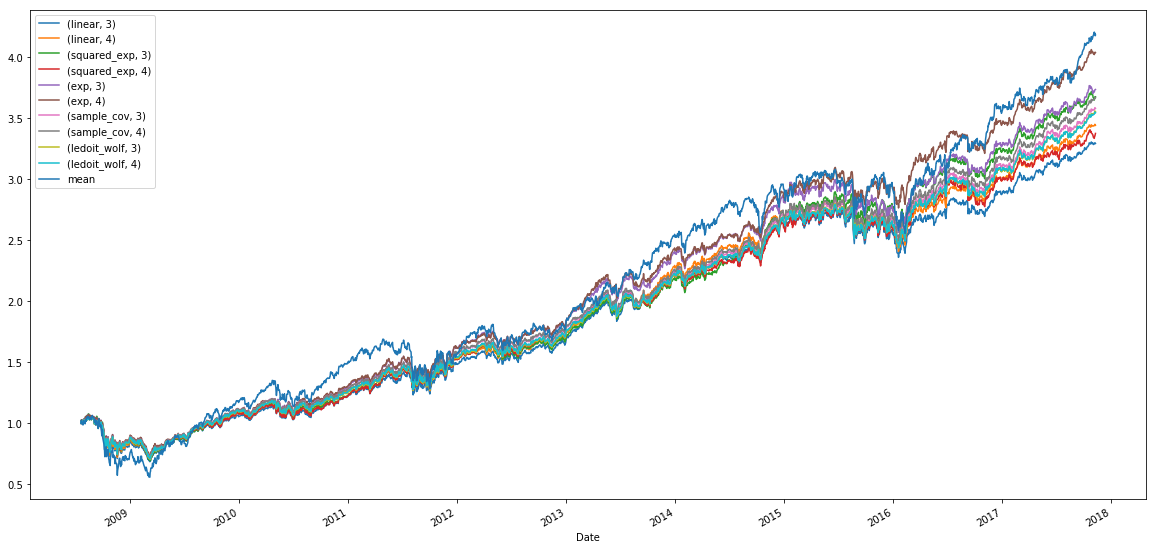

In [10]:
idx = [(model_name, Q) for model_name in model_names for Q in Qs] + ['mean',]
df_performance = pd.DataFrame(index=idx, columns=data.index)

for now, df_g in results.groupby(by='now'):
    idx =  [(i,j) for i,j in df_g.loc[:,['model_name', 'Q']].values]
    ret = np.matmul(df_g.filter(regex='^w'), data.loc[now:now+delta, :].T)
    df_performance.loc[idx, now:now+delta] = ret
    df_performance.loc['mean', now:now+delta] = np.matmul(1./N*np.ones(shape=(1, N)),
                                                          data.loc[now:now+delta, :].T)

df_performance.dropna(axis=1, inplace=True)

mean = lambda x: x.mean()*250
std = lambda x: x.std()*np.sqrt(250)
sharpe_ratio = lambda x: mean(x)/std(x)

df_performance_eval = df_performance.T.apply([mean, std, sharpe_ratio])
df_performance_eval.index = ['mean', 'std', 'sharp ratio']
display(df_performance_eval)

np.cumprod(1+df_performance.T).plot(figsize=(20,10));